<a href="https://colab.research.google.com/github/mobarakol/AI_Medical_Imaging/blob/main/Practical_2_AttentionMap_Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Brain Tumor Dataset<br>
source: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset<br>
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']<br>
number of training MRIs slices = 5712 <br>
number of testing MRIs slices = 1311 <br>

Download the dataset:

In [2]:
import gdown

url = 'https://drive.google.com/uc?id=1Oms9X0Vpid_kN8jiSgz-3MhRA5BcmivE'
gdown.download(url,'braintumor.zip',quiet=True)
!unzip -q braintumor.zip -d braintumor

Download my trained weights:

In [3]:
import gdown

!mkdir myweights

#ViT
url = 'https://drive.google.com/uc?id=1yYBUwjxmrjQevBPleZAQeEyHR-Pq5wWB'
gdown.download(url,'myweights/best_model_vit.pth.tar',quiet=True)

'myweights/best_model_vit.pth.tar'

Sample Data:

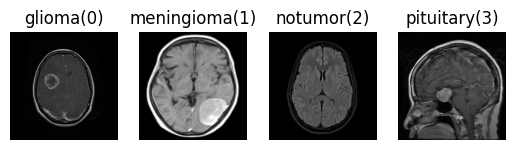

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        normalize,
    ])

class_names = ['glioma(0)', 'meningioma(1)', 'notumor(2)', 'pituitary(3)']

newsize = (224, 224)
img_glioma = Image.open('/content/braintumor/Testing/glioma/Te-gl_0014.jpg').resize(newsize)
img_meningioma = Image.open('/content/braintumor/Testing/meningioma/Te-me_0017.jpg').resize(newsize)
img_healthy = Image.open('/content/braintumor/Testing/notumor/Te-noTr_0002.jpg').resize(newsize)
img_pituitary = Image.open('/content/braintumor/Testing/pituitary/Te-piTr_0008.jpg').resize(newsize)
plt.subplot(1,4,1), plt.axis('OFF'), plt.title(class_names[0]), plt.imshow(img_glioma)
plt.subplot(1,4,2), plt.axis('OFF'),plt.title(class_names[1]), plt.imshow(img_meningioma)
plt.subplot(1,4,3), plt.axis('OFF'),plt.title(class_names[2]), plt.imshow(img_healthy)
plt.subplot(1,4,4), plt.axis('OFF'),plt.title(class_names[3]), plt.imshow(img_pituitary);

Vision Transformer

<ipython-input-6-0de19bceab58>:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar'))
/usr/local/lib/python3

1
torch.Size([1, 50, 768])
results torch.Size([1, 7, 7, 768])
results torch.Size([1, 7, 7, 768])
activations torch.Size([1, 768, 7, 7])


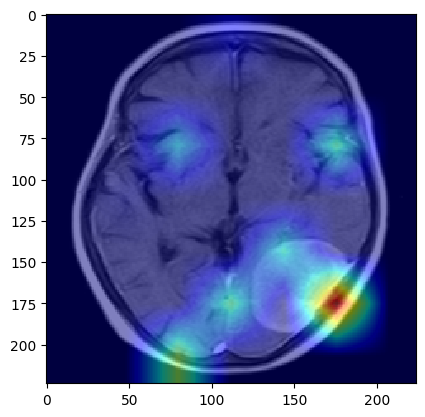

In [6]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from torchvision import models
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.cm as cm


def reg_hook_gradcam(last_conv_layer=None):
    # gradients for gradcam are stored here
    stored_grads = torch.Tensor([])
    stored_fpass = torch.Tensor([])

    def bpass_hook(self, gin, gout):
        global stored_grads
        stored_grads = gout

    def fpass_hook(self, ten_in, ten_out):
        global stored_fpass
        stored_fpass = ten_out

    handle_b = last_conv_layer.register_backward_hook(bpass_hook)
    handle_f = last_conv_layer.register_forward_hook(fpass_hook)

def reshape_transform(tensor, height=7, width=7):
    result = tensor[:, 1:, :].reshape(tensor.size(0),
                                      height, width, tensor.size(2))
    print('results', result.shape)
    # Bring the channels to the first dimension like in CNNs.
    result = result.transpose(2, 3).transpose(1, 2)
    return result

def get_gradcam(model, img, gradcampp=False, last_conv_layer=None):
    reg_hook_gradcam(last_conv_layer=last_conv_layer)
    logits = model(img)
    pred = logits.argmax(dim=1).item()
    print(pred)
    logits[:, pred].backward(retain_graph=True)
    img_hmap = np.transpose(img.squeeze().cpu().numpy(),(1,2,0))
    gradients = stored_grads[0].clone()
    activations = stored_fpass[0].clone().unsqueeze(0)
    print(gradients.shape)
    gradients = reshape_transform(gradients)
    activations = reshape_transform(activations)
    print('activations', activations.shape)
    activations = activations.detach()
    pooled_gradients = torch.mean(gradients, dim=[2, 3])
    activations *= pooled_gradients[:,:,None, None]
    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap


model = models.vision_transformer.vit_b_32()
model.heads = nn.Linear(model.heads[0].in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar'))
last_conv_layer = model.encoder.layers[11].ln_1
img = my_transform(img_meningioma).unsqueeze(0)
heatmap = get_gradcam(model, img, last_conv_layer=last_conv_layer)

img_np = np.array(img_meningioma)
heatmap = cv2.resize(np.array(heatmap), (img_np.shape[1], img_np.shape[0]))

plt.imshow(img_np, interpolation='nearest', cmap='gray')
plt.imshow(heatmap, interpolation='nearest', cmap=cm.jet, alpha=0.5, vmin=0, vmax=1)

print layer names:

In [21]:
import torch
from torchvision import models
import torch.nn as nn

# Load a Vision Transformer model (here we use vit_b_32)
model = models.vision_transformer.vit_b_32(pretrained=True)

# Iterate over each encoder block and count the MultiheadAttention modules
for i, block in enumerate(model.encoder.layers):
    # Find all submodules in the block that are instances of MultiheadAttention.
    mha_modules = [m for m in block.modules() if isinstance(m, nn.MultiheadAttention)]
    print(f"Encoder Block {i}:")
    print(f"  Number of MultiheadAttention modules: {len(mha_modules)}")

    # If available, print number of heads from each module.
    for j, mha in enumerate(mha_modules):
        if hasattr(mha, 'num_heads'):
            print(f"    Module {j}: {mha.num_heads} heads")
        else:
            print(f"    Module {j}: number of heads not available")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_32_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_32_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth
100%|██████████| 337M/337M [00:02<00:00, 150MB/s]


Encoder Block 0:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 1:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 2:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 3:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 4:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 5:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 6:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 7:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 8:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 9:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 10:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads
Encoder Block 11:
  Number of MultiheadAttention modules: 1
    Module 0: 12 heads


In [23]:
model

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

visualize average attention map in last block

<ipython-input-7-0f304daf1900>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.devi

Predicted class: 1


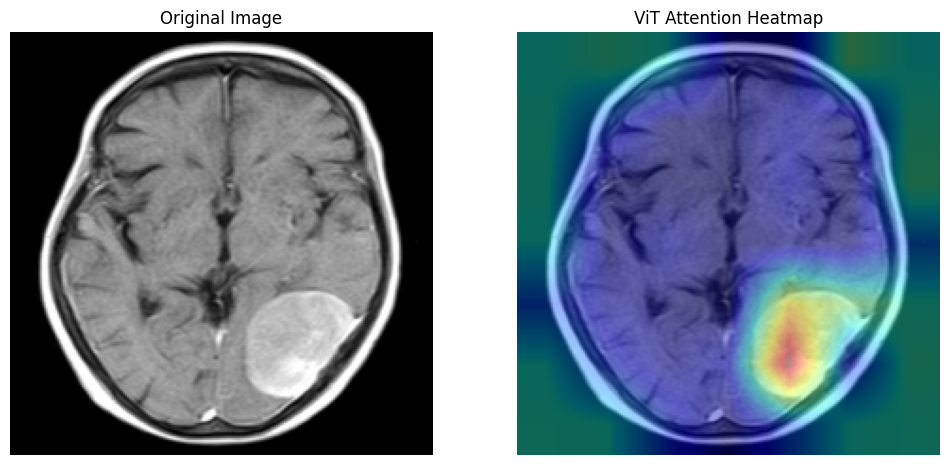

In [7]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# --- Preprocessing ---
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

newsize = (224, 224)
img_path = '/content/braintumor/Testing/meningioma/Te-me_0017.jpg'
img = Image.open(img_path).convert("RGB").resize(newsize)
img_tensor = my_transform(img).unsqueeze(0)  # shape: [1, 3, 224, 224]

# --- Load ViT and Trained Weights ---
model = models.vision_transformer.vit_b_32()
model.heads = nn.Linear(model.heads[0].in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.device('cpu')))
model.eval()

# --- Monkey-Patch MultiheadAttention to Always Return Attention Weights ---
# For torch.nn.MultiheadAttention, we override its forward method so that it always returns attn weights.
def patched_forward(self, query, key, value, key_padding_mask=None, need_weights=True, attn_mask=None):
    # Force need_weights=True regardless of the caller's argument.
    need_weights = True
    # Call the original forward method
    out, weights = self.__original_forward__(query, key, value,
                                             key_padding_mask=key_padding_mask,
                                             need_weights=need_weights,
                                             attn_mask=attn_mask)
    # Store the attention weights in an attribute for later retrieval
    self.last_attn = weights  # shape: [B, num_heads, N, N]
    return out, weights

# Patch all MultiheadAttention modules in the encoder layers.
for name, module in model.named_modules():
    if isinstance(module, nn.MultiheadAttention):
        # Save the original forward method so we can call it inside our patched version.
        module.__original_forward__ = module.forward
        module.forward = patched_forward.__get__(module, module.__class__)

# --- Forward Pass ---
with torch.no_grad():
    logits = model(img_tensor)
    pred = logits.argmax(dim=1).item()
    print("Predicted class:", pred)

# --- Extract Attention from the Last Encoder Block ---
# According to your architecture, the last encoder block is in model.encoder.layers[-1],
# and its self-attention module is under the attribute 'self_attention'.
last_block = model.encoder.layers[-1]
last_attn = last_block.self_attention.last_attn  # shape: [B, num_heads, N, N]

# --- Process the Attention Map ---
# Average over the heads: result shape [B, N, N]
avg_attn = last_attn.mean(dim=1)
# In ViT, token 0 is the CLS token. We extract its attention weights to the image patches (skip the CLS token itself).
cls_attn = avg_attn[0, 1:]  # shape: [num_tokens - 1]
# For ViT-B/32, the image is split into 7x7 patches → 49 patches.
cls_attn_map = cls_attn.reshape(7, 7).cpu().numpy()

# --- Create a Heatmap ---
# Resize the 7x7 attention map to match the input image size (224x224)
attn_map_resized = cv2.resize(cls_attn_map, (224, 224))
# Normalize the attention map to [0,1]
attn_map_norm = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min())
# Map to a Jet heatmap
heatmap = cm.jet(attn_map_norm)[:, :, :3]  # Drop alpha channel
heatmap = np.uint8(255 * heatmap)

# --- Overlay Heatmap on Original Image ---
img_np = np.array(img)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# --- Visualize ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("ViT Attention Heatmap")
plt.axis("off")
plt.show()


Visualizing mean attention map from each Attention Block

<ipython-input-20-c35a4d68e4e8>:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.dev

Predicted class: 1


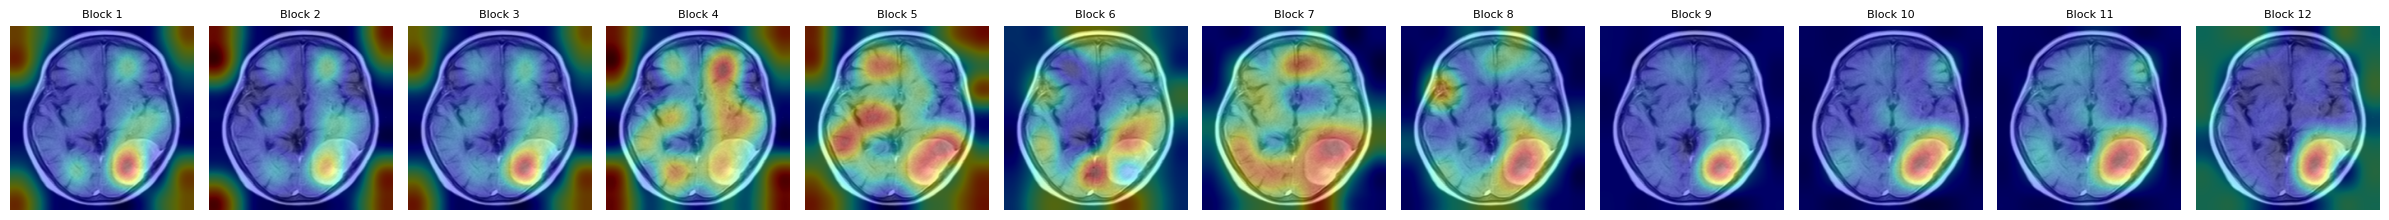

In [20]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# --- Preprocessing ---
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])
newsize = (224, 224)
img_path = '/content/braintumor/Testing/meningioma/Te-me_0017.jpg'
img = Image.open(img_path).convert("RGB").resize(newsize)
img_tensor = my_transform(img).unsqueeze(0)  # shape: [1, 3, 224, 224]
# Also get the original image as a NumPy array for overlay (RGB)
img_np = np.array(img)

# --- Load ViT and Trained Weights ---
model = models.vision_transformer.vit_b_32()
model.heads = nn.Linear(model.heads[0].in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.device('cpu')))
model.eval()

# --- Monkey-Patch MultiheadAttention to Return Attention Weights ---
def patched_forward(self, query, key, value, key_padding_mask=None, need_weights=True, attn_mask=None):
    need_weights = True  # Force returning weights
    out, weights = self.__original_forward__(query, key, value,
                                             key_padding_mask=key_padding_mask,
                                             need_weights=need_weights,
                                             attn_mask=attn_mask)
    self.last_attn = weights  # shape: [B, num_heads, N, N]
    return out, weights

# Patch all MultiheadAttention modules in the encoder layers.
for name, module in model.named_modules():
    if isinstance(module, nn.MultiheadAttention):
        module.__original_forward__ = module.forward
        module.forward = patched_forward.__get__(module, module.__class__)

# --- Forward Pass ---
with torch.no_grad():
    logits = model(img_tensor)
    pred = logits.argmax(dim=1).item()
    print("Predicted class:", pred)

# --- Extract and Process Attention Maps for Each of the 12 Blocks ---
overlay_list = []  # To store overlay images for each block
num_blocks = len(model.encoder.layers)  # Should be 12 for ViT-B/32

for i, block in enumerate(model.encoder.layers):
    # Extract attention weights from the block's self_attention module.
    # Expected shape: [B, num_heads, N, N]
    attn = block.self_attention.last_attn
    # Average over heads: shape becomes [B, N, N]
    attn_avg = attn.mean(dim=1)
    # In ViT, token 0 is CLS. Extract its attention to the image patches (skip token 0).
    cls_attn = attn_avg[0, 1:]  # shape: [num_tokens - 1]
    # For ViT-B/32, the image is split into 7x7 patches (49 tokens)
    cls_attn_map = cls_attn.reshape(7, 7).cpu().numpy()

    # Upsample the 7x7 map to match the input image size (224x224)
    cls_attn_map_up = cv2.resize(cls_attn_map, (224, 224), interpolation=cv2.INTER_CUBIC)
    # Normalize the map to [0,1]
    cls_attn_map_norm = (cls_attn_map_up - cls_attn_map_up.min()) / (cls_attn_map_up.max() - cls_attn_map_up.min() + 1e-8)
    # Map the normalized attention to a Jet heatmap (dropping the alpha channel)
    heatmap = cm.jet(cls_attn_map_norm)[:, :, :3]
    heatmap = np.uint8(255 * heatmap)

    # Create an overlay of the heatmap with the input image.
    # Blend 60% of the original image with 40% of the heatmap.
    overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)
    overlay_list.append(overlay)

# --- Visualize All 12 Overlays in One Row ---
plt.figure(figsize=(24, 4))
for i, overlay in enumerate(overlay_list):
    plt.subplot(1, 12, i + 1)
    plt.imshow(overlay)
    plt.title(f"Block {i+1}", fontsize=8)
    plt.axis("off")
plt.tight_layout()
plt.show()


Visualizing mean attention heatmap from each Attention Block

<ipython-input-16-f78a796a91d5>:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.dev

Predicted class: 1


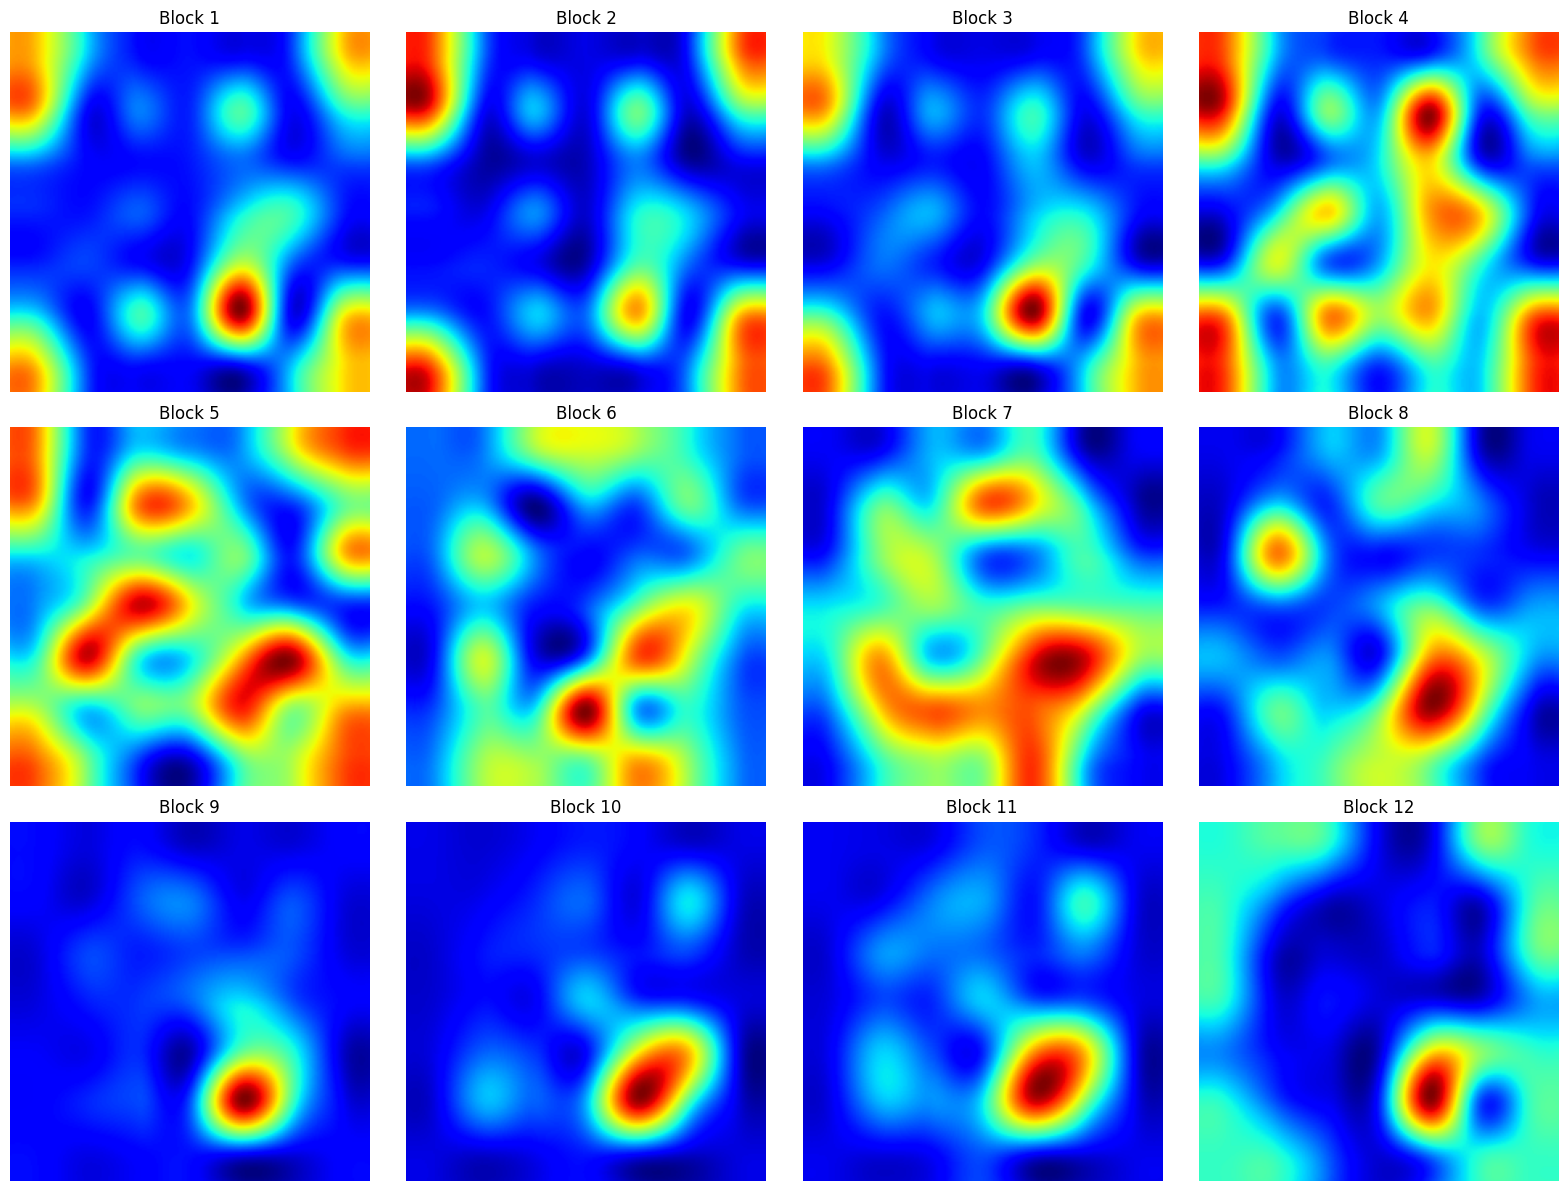

In [16]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# --- Preprocessing ---
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])
newsize = (224, 224)
img_path = '/content/braintumor/Testing/meningioma/Te-me_0017.jpg'
img = Image.open(img_path).convert("RGB").resize(newsize)
img_tensor = my_transform(img).unsqueeze(0)  # shape: [1, 3, 224, 224]

# --- Load ViT and Trained Weights ---
model = models.vision_transformer.vit_b_32()
model.heads = nn.Linear(model.heads[0].in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.device('cpu')))
model.eval()

# --- Monkey-Patch MultiheadAttention to Return Attention Weights ---
def patched_forward(self, query, key, value, key_padding_mask=None, need_weights=True, attn_mask=None):
    need_weights = True  # Force returning weights
    out, weights = self.__original_forward__(query, key, value,
                                             key_padding_mask=key_padding_mask,
                                             need_weights=need_weights,
                                             attn_mask=attn_mask)
    self.last_attn = weights  # shape: [B, num_heads, N, N]
    return out, weights

# Patch all MultiheadAttention modules in the encoder layers.
for name, module in model.named_modules():
    if isinstance(module, nn.MultiheadAttention):
        module.__original_forward__ = module.forward
        module.forward = patched_forward.__get__(module, module.__class__)

# --- Forward Pass ---
with torch.no_grad():
    logits = model(img_tensor)
    pred = logits.argmax(dim=1).item()
    print("Predicted class:", pred)

# --- Extract and Process Attention Maps from All 12 Blocks ---
# Each encoder block is stored in model.encoder.layers (12 blocks in total)
heatmaps = []  # To hold the processed heatmap for each block
num_blocks = len(model.encoder.layers)

for i, block in enumerate(model.encoder.layers):
    # Get attention weights from this block's self_attention module.
    # The attention weights tensor shape: [B, num_heads, N, N]
    attn = block.self_attention.last_attn
    # Average over the heads: shape becomes [B, N, N]
    attn_avg = attn.mean(dim=1)
    # In ViT, token 0 is the CLS token.
    # We extract its attention to the image patches (skip the first token).
    cls_attn = attn_avg[0, 1:]  # shape: [num_tokens-1]
    # For ViT-B/32, the image is divided into 7x7 patches → 49 patches.
    cls_attn_map = cls_attn.reshape(7, 7).cpu().numpy()

    # Upsample the 7x7 attention map to the input image size (224x224)
    cls_attn_map_up = cv2.resize(cls_attn_map, (224, 224), interpolation=cv2.INTER_CUBIC)
    # Normalize to [0, 1]
    cls_attn_map_norm = (cls_attn_map_up - cls_attn_map_up.min()) / (cls_attn_map_up.max() - cls_attn_map_up.min() + 1e-8)
    # Map the normalized attention to a Jet colormap
    heatmap = cm.jet(cls_attn_map_norm)[:, :, :3]  # Drop alpha channel
    heatmap = np.uint8(255 * heatmap)
    heatmaps.append(heatmap)

# --- Visualize the 12 Heatmaps in a Grid ---
plt.figure(figsize=(16, 12))
for i, hm in enumerate(heatmaps):
    plt.subplot(3, 4, i+1)
    plt.imshow(hm)
    plt.title(f"Block {i+1}")
    plt.axis("off")
plt.tight_layout()
plt.show()


<ipython-input-14-1701cb08e10a>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.dev

Predicted class: 1


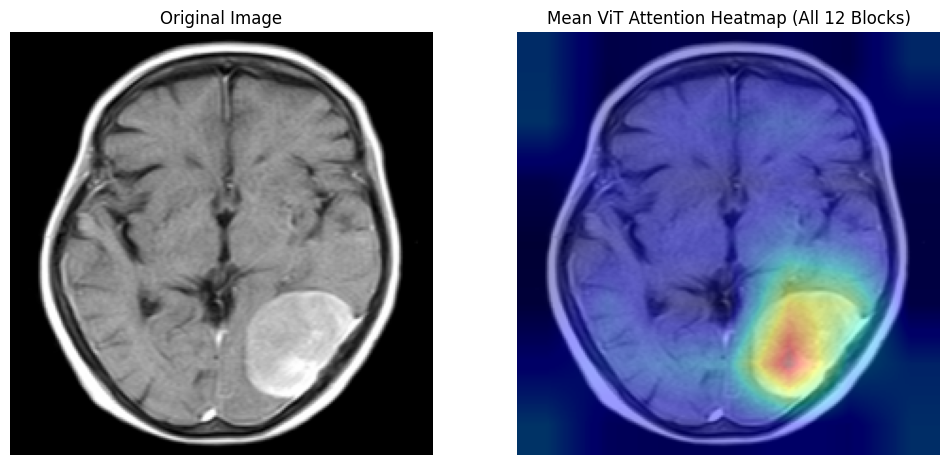

In [14]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# --- Preprocessing ---
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

newsize = (224, 224)
img_path = '/content/braintumor/Testing/meningioma/Te-me_0017.jpg'
img = Image.open(img_path).convert("RGB").resize(newsize)
img_tensor = my_transform(img).unsqueeze(0)  # shape: [1, 3, 224, 224]

# --- Load ViT and Trained Weights ---
model = models.vision_transformer.vit_b_32()
model.heads = nn.Linear(model.heads[0].in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.device('cpu')))
model.eval()

# --- Monkey-Patch MultiheadAttention to Always Return Attention Weights ---
def patched_forward(self, query, key, value, key_padding_mask=None, need_weights=True, attn_mask=None):
    # Force need_weights=True regardless of the caller's argument.
    need_weights = True
    # Call the original forward method
    out, weights = self.__original_forward__(query, key, value,
                                             key_padding_mask=key_padding_mask,
                                             need_weights=need_weights,
                                             attn_mask=attn_mask)
    # Store the attention weights in an attribute for later retrieval
    self.last_attn = weights  # shape: [B, num_heads, N, N]
    return out, weights

# Patch all MultiheadAttention modules in the encoder layers.
for name, module in model.named_modules():
    if isinstance(module, nn.MultiheadAttention):
        module.__original_forward__ = module.forward
        module.forward = patched_forward.__get__(module, module.__class__)

# --- Forward Pass ---
with torch.no_grad():
    logits = model(img_tensor)
    pred = logits.argmax(dim=1).item()
    print("Predicted class:", pred)

# --- Extract and Average Attention from All Encoder Blocks ---
# Each block in model.encoder.layers is an EncoderBlock.
# We'll average the attention weights from the self_attention module in each block.
attn_list = []
num_blocks = len(model.encoder.layers)
for block in model.encoder.layers:
    # Get attention weights from each block: shape [B, num_heads, N, N]
    attn = block.self_attention.last_attn
    # Average over heads to get shape [B, N, N]
    attn_avg = attn.mean(dim=1)
    attn_list.append(attn_avg)

# Compute the mean attention map across all blocks: shape [B, N, N]
mean_attn_all = torch.stack(attn_list, dim=0).mean(dim=0)

# --- Process the Mean Attention Map ---
# In ViT, token 0 is the CLS token. We extract its attention to image patches (skip CLS itself).
cls_attn = mean_attn_all[ 0, 1:]  # shape: [num_tokens - 1]
# For ViT-B/32, the image is split into 7x7 patches → 49 tokens.
cls_attn_map = cls_attn.reshape(7, 7).cpu().numpy()

# --- Create a Heatmap ---
# Resize the 7x7 attention map to match the input image size (224x224)
attn_map_resized = cv2.resize(cls_attn_map, (224, 224))
# Normalize the attention map to [0,1]
attn_map_norm = (attn_map_resized - attn_map_resized.min()) / (attn_map_resized.max() - attn_map_resized.min())
# Map to a Jet heatmap (drop the alpha channel)
heatmap = cm.jet(attn_map_norm)[:, :, :3]
heatmap = np.uint8(255 * heatmap)

# --- Overlay Heatmap on Original Image ---
img_np = np.array(img)
overlay = cv2.addWeighted(img_np, 0.6, heatmap, 0.4, 0)

# --- Visualize ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(img_np)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(overlay)
plt.title("Mean ViT Attention Heatmap (All 12 Blocks)")
plt.axis("off")
plt.show()


Visualize Attention Map for Each Patch/Token

<ipython-input-12-4042a2e98212>:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.dev

Predicted class: 1


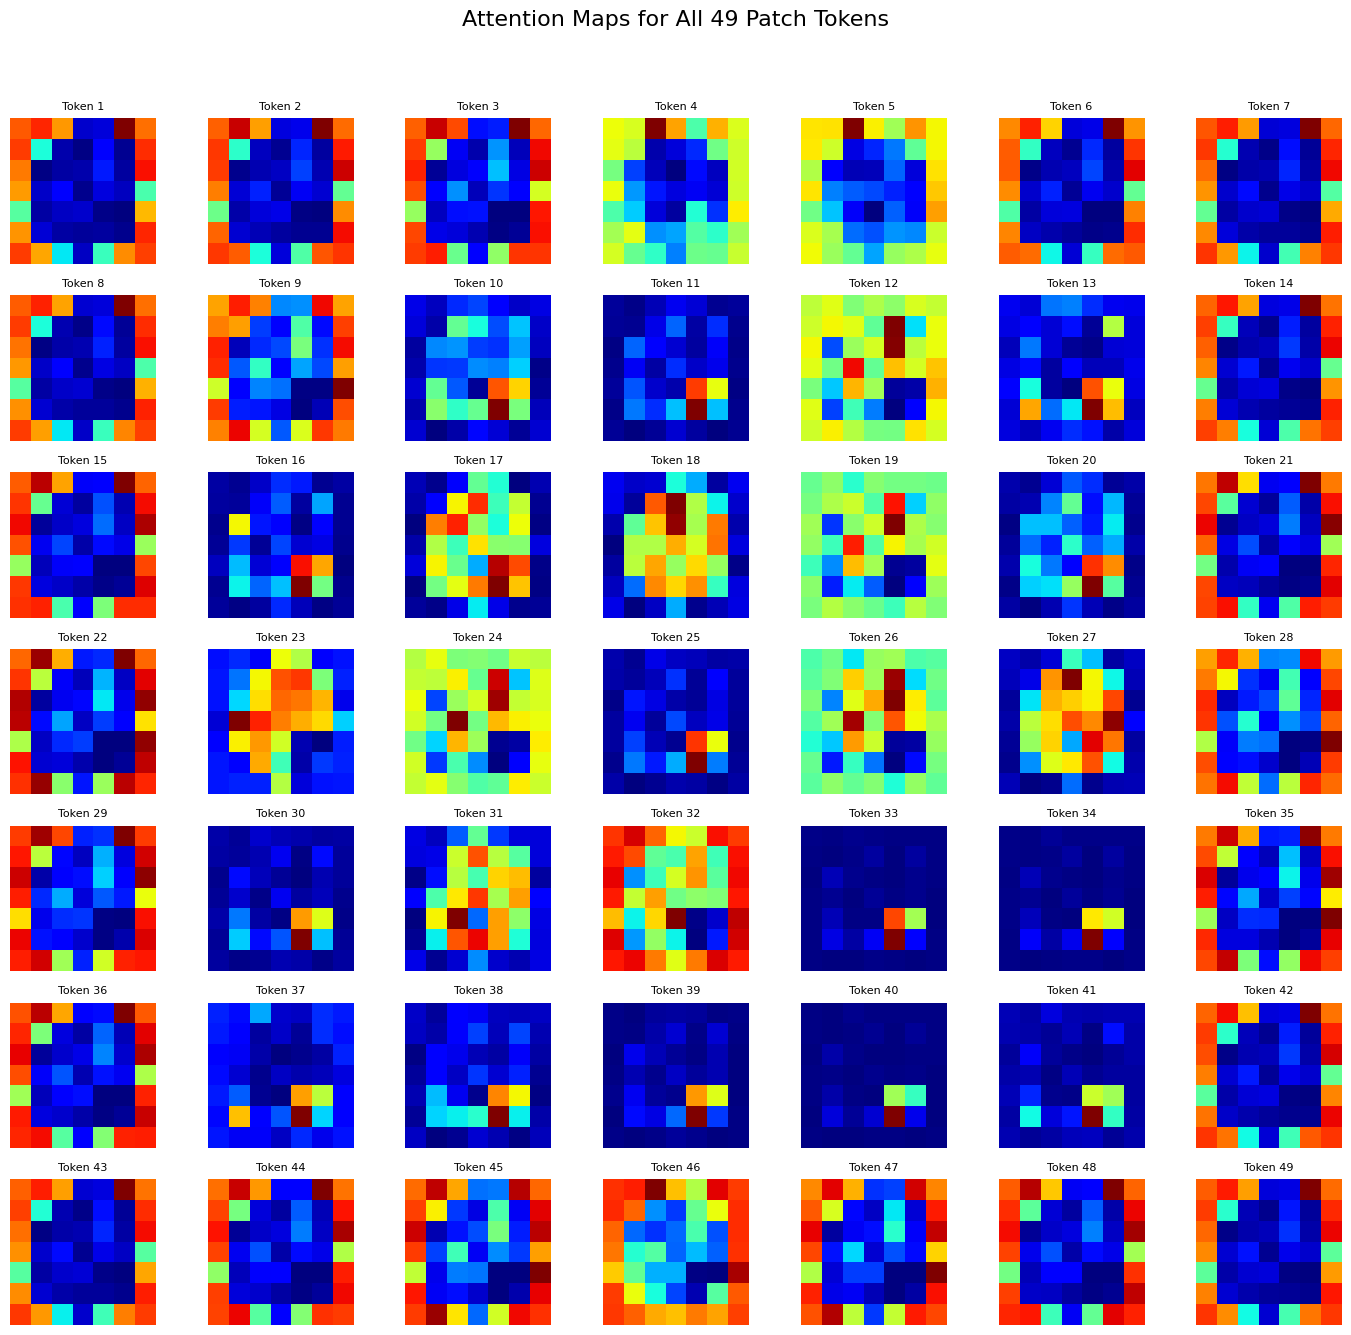

In [12]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from torchvision import models
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

# --- Preprocessing ---
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
my_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

newsize = (224, 224)
img_path = '/content/braintumor/Testing/meningioma/Te-me_0017.jpg'
img = Image.open(img_path).convert("RGB").resize(newsize)
img_tensor = my_transform(img).unsqueeze(0)  # shape: [1, 3, 224, 224]

# --- Load ViT and Trained Weights ---
model = models.vision_transformer.vit_b_32()
model.heads = nn.Linear(model.heads[0].in_features, 4)
model.load_state_dict(torch.load('myweights/best_model_vit.pth.tar', map_location=torch.device('cpu')))
model.eval()

# --- Monkey-Patch MultiheadAttention to Always Return Attention Weights ---
def patched_forward(self, query, key, value, key_padding_mask=None, need_weights=True, attn_mask=None):
    need_weights = True  # Force returning attention weights
    out, weights = self.__original_forward__(query, key, value,
                                             key_padding_mask=key_padding_mask,
                                             need_weights=need_weights,
                                             attn_mask=attn_mask)
    self.last_attn = weights  # shape: [B, num_heads, N, N] OR, if averaged, shape: [B, N, N]
    return out, weights

# Patch all MultiheadAttention modules in the encoder layers.
for name, module in model.named_modules():
    if isinstance(module, nn.MultiheadAttention):
        module.__original_forward__ = module.forward
        module.forward = patched_forward.__get__(module, module.__class__)

# --- Forward Pass ---
with torch.no_grad():
    logits = model(img_tensor)
    pred = logits.argmax(dim=1).item()
    print("Predicted class:", pred)

# --- Extract Attention from the Last Encoder Block ---
# The last encoder block is model.encoder.layers[-1] and its attention module is under 'self_attention'.
last_block = model.encoder.layers[-1]
last_attn = last_block.self_attention.last_attn  # e.g., shape: [1, 50, 50] if averaged

# Instead of averaging over heads (if already averaged), simply squeeze the batch dimension:
attn_tensor = last_attn.squeeze(0)  # shape: [50, 50]

# --- Visualize All 49 Attention Maps ---
# For ViT-B/32, we have 50 tokens: index 0 is CLS, and indices 1 to 49 are patch tokens.
# For each patch token, we extract its attention vector (excluding the CLS column) and reshape it to a 7x7 grid.
fig, axs = plt.subplots(7, 7, figsize=(14, 14))
fig.suptitle("Attention Maps for All 49 Patch Tokens", fontsize=16)

for i in range(49):
    # Token index i+1 corresponds to one of the 49 patch tokens.
    # Exclude the CLS column (index 0) from the attention vector.
    attn_vec = attn_tensor[i+1, 1:]  # shape: [49]
    attn_map = attn_vec.reshape(7, 7).cpu().numpy()
    # Normalize the map for visualization.
    attn_map_norm = (attn_map - attn_map.min()) / (attn_map.max() - attn_map.min() + 1e-8)
    axs[i//7, i%7].imshow(attn_map_norm, cmap='jet')
    axs[i//7, i%7].set_title(f'Token {i+1}', fontsize=8)
    axs[i//7, i%7].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [10]:
avg_attn.shape

torch.Size([1, 50])